In [1]:
import pandas as pd

"""
Generate Figure 3 a,c
"""
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.ticker
import matplotlib
import netCDF4 as nc
import os
# define precipitation thresholds for three climate zones
Wet=570;Dry=180


FilePath='/home/jguo/research/hw_global/keer_plot/Data'


# FilePath='B:\\HeatStressPaper2022_v2\\Revision2\\Upload_20221130\\Data\\'
Precipitation=nc.Dataset(os.path.join(FilePath, 'SummerPrecipitation.nc'))
Rain=Precipitation.variables['Precip'][:]

PartitionTerms=nc.Dataset(os.path.join(FilePath, 'PartitionTerms.nc'))
DaytimeDeltaTw=PartitionTerms.variables['DaytimeDeltaTw'][:]
NighttimeDeltaTw=PartitionTerms.variables['NighttimeDeltaTw'][:]


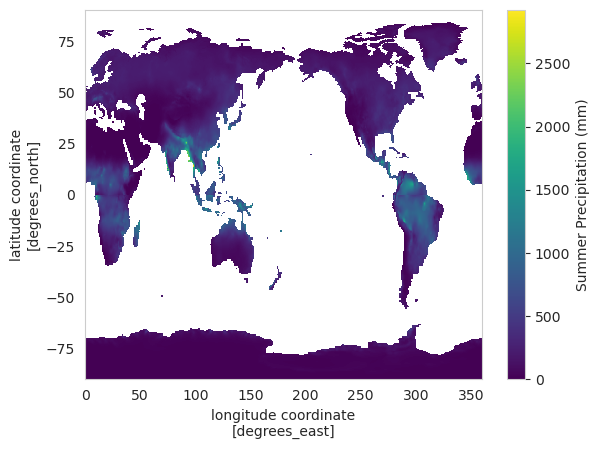

In [2]:
import xarray as xr
import numpy as np
ds = xr.open_dataset(os.path.join(FilePath, 'SummerPrecipitation.nc'))
ds
ds['Precip'].plot()

In [6]:
ds

<xarray.Dataset>
Dimensions:  (lat: 768, lon: 1152)
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
Data variables:
    Precip   (lat, lon) float32 ...

In [3]:
ds['Precip'].to_dataframe().describe()

,Precip
count,311857.000000
mean,203.461990
std,254.927277
min,0.000000
25%,14.690757
50%,123.470673
75%,259.130280
max,2923.197754


In [4]:
import xarray as xr
import numpy as np
ds_term = xr.open_dataset(os.path.join(FilePath, 'PartitionTerms.nc'))
ds_term

<xarray.Dataset>
Dimensions:                         (lat: 768, lon: 1152)
Coordinates:
  * lat                             (lat) float64 -90.0 -89.77 ... 89.77 90.0
  * lon                             (lon) float64 0.0 0.3125 ... 359.4 359.7
Data variables: (12/13)
    area                            (lat, lon) float32 ...
    DaytimeDeltaTw                  (lat, lon) float32 ...
    DaytimeConvectionTerm           (lat, lon) float32 ...
    DaytimeAnthropogenicHeatTerm    (lat, lon) float32 ...
    DaytimeHeatStorageTerm          (lat, lon) float32 ...
    DaytimeSolarAbsorptionTerm      (lat, lon) float32 ...
    ...                              ...
    NighttimeDeltaTw                (lat, lon) float32 ...
    NighttimeConvectionTerm         (lat, lon) float32 ...
    NighttimeAnthropogenicHeatTerm  (lat, lon) float32 ...
    NighttimeHeatStorageTerm        (lat, lon) float32 ...
    NighttimeSolarAbsorptionTerm    (lat, lon) float32 ...
    NighttimeLongwaveRadTerm        (lat, lon) float32 ...

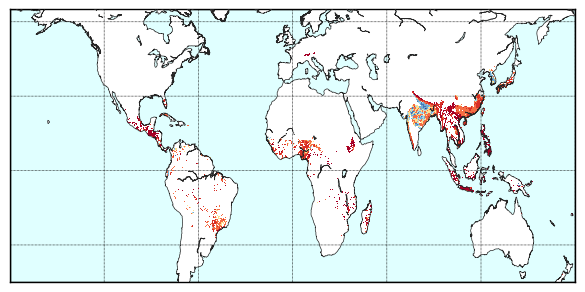

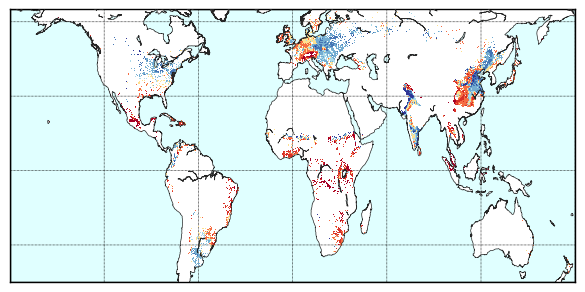

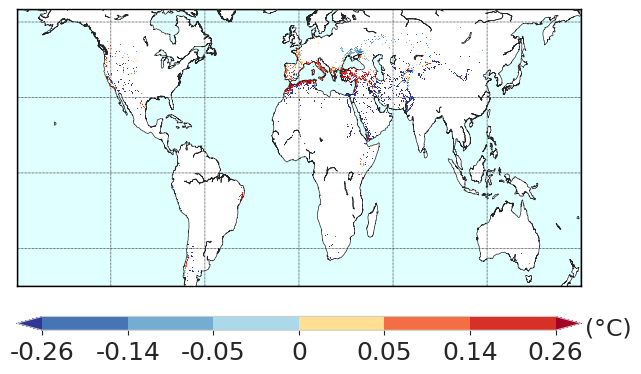

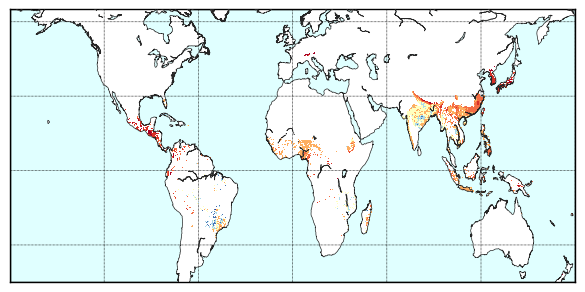

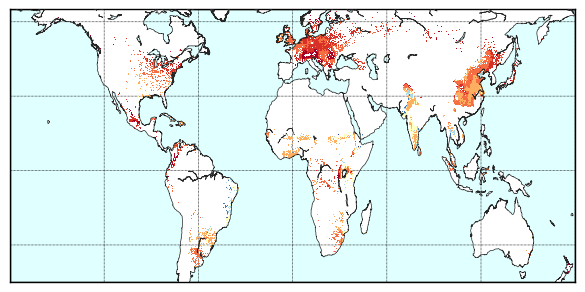

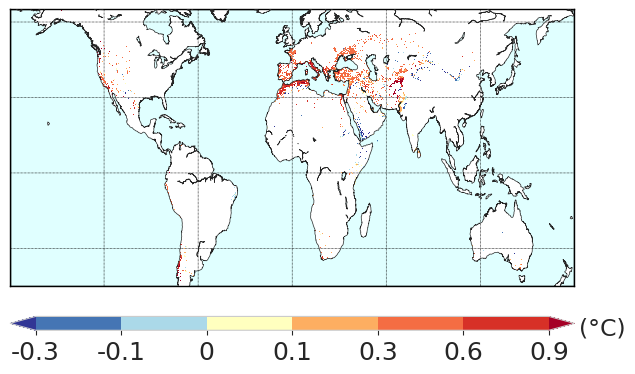

In [5]:

Rain=Rain[192:662,:]# only plot 44.94133S to 65.12386 N
Rain=np.ma.concatenate((Rain[:,576:1152],Rain[:,0:576]),axis=1) # flip longitude
""" 
BasemapPlot
Description: a function to visualize 2D global data
Input:  TobePlot --2D data to be visualized
        Label --Variable name
        colorscheme --colorscheme
        DN -- day or night designation 
        Zone -- climate zone (wet/inter/dry)
"""
def BasemapPlot(TobePlot, Label, colorscheme,DN,Zone):
    lat = 470
    lon = 1152

    m = Basemap(projection='cyl',lon_0=0.,lat_0=0.,lat_ts=0.,fix_aspect=False, \
                llcrnrlat=-44.94133,urcrnrlat=65.12386, \
                llcrnrlon=-180,urcrnrlon=180.0, \
                rsphere=6371200.,resolution='l',area_thresh=10000)
    m.drawmapboundary(fill_color='lightcyan') #
    m.fillcontinents(color='white',lake_color='lightcyan')
    m.drawcoastlines(color = '0.15',linewidth=0.5,zorder=3)

    # draw parallels.
    parallels = np.arange(-90.,100.,30.)
    m.drawparallels(parallels,labels=[0,0,0,0],fontsize=10,linewidth=0.5)
    # draw meridians
    meridians = np.arange(0.,360.,60.)
    m.drawmeridians(meridians,labels=[0,0,0,0],fontsize=0,linewidth=0.5)

    ny = lat; nx = lon
    lons, lats = m.makegrid(nx, ny) # get lat/lons of ny by nx evenly space grid.
    x, y = m(lons, lats) # compute map proj coordinates.

    if Zone=='Wet':
        TobePlot=np.ma.masked_where(Rain<Wet, TobePlot)
    elif Zone=='Inter':
        TobePlot=np.ma.masked_where((Rain>=Wet)|(Rain<=Dry), TobePlot)
    elif Zone=='Dry':
        TobePlot=np.ma.masked_where((Rain>Dry), TobePlot)

    if DN=='Day':
        clevsVPDif = [-0.26,-0.14,-0.05,0,0.05,0.14,0.26]
        colors = ['#313695','#4575b4', '#74add1','#abd9e9','#fee090','#f46d43','#d73027','#a50026']

    elif DN=='Night':
        clevsVPDif = [-0.3,-0.1,0,0.1,0.3,0.6,0.9]
        colors = ['#313695','#4575b4', '#abd9e9','#ffffbf','#fdae61','#f46d43','#d73027','#a50026']

    cmap, norm = matplotlib.colors.from_levels_and_colors(clevsVPDif, colors, extend='both')

    cs = m.pcolormesh(x,y,TobePlot,zorder=2,cmap=cmap, norm=norm, shading='auto')

    if Zone=='Dry':
        cbar = m.colorbar(cs,location='bottom',pad="11%", extend="both",fraction=0.1,aspect=15)
        fig.canvas.flush_events()
        cbar.ax.set_xticklabels(labels=clevsVPDif, fontsize=18)   #, weight='bold'
        if DN=='Day':
            cbar.ax.text(0.88,0.15,'(°C)', horizontalalignment='center',verticalalignment='center', size=17)
        elif DN=='Night':
            cbar.ax.text(1.52,0.15,'(°C)', horizontalalignment='center',verticalalignment='center', size=17)

VarName='ΔTw'
Cmap='jet'
ClimateZones=['Wet','Inter','Dry']
for i in range(0,3):
    Zone=ClimateZones[i]
    if Zone=='Dry':
        # dry climate figure should be larger because it has legend bar
        fig,ax = plt.subplots(figsize=(6.4, 3.7))
        wi=0.915
        bo=0.085
    else:
        fig,ax = plt.subplots(figsize=(6, 3.2))
        wi=0.975
        bo=0.100
    TobePlot=DaytimeDeltaTw
    TobePlot=np.ma.concatenate((TobePlot[:,576:1152],TobePlot[:,0:576]),axis=1)   # flip longitude
    TobePlot=TobePlot[192:662,:] # only plot 44.94133S to 65.12386 N
    BasemapPlot(TobePlot, VarName, Cmap,'Day',Zone)
    plt.subplots_adjust(top=0.953,
                        bottom=bo,
                        left=0.033,
                        right=wi,
                        hspace=0.2,
                        wspace=0.2)
    # plt.savefig(FilePath+'Figure3a'+Zone+'.png', dpi=600)    
    # plt.close()

for i in range(0,3):
    Zone=ClimateZones[i]
    if Zone=='Dry':
        # dry climate figure should be larger because it has legend bar
        fig,ax = plt.subplots(figsize=(6.4, 3.7))
        wi=0.915
        bo=0.085
    else:
        fig,ax = plt.subplots(figsize=(6, 3.2))
        wi=0.975
        bo=0.100
    TobePlot=NighttimeDeltaTw
    TobePlot=np.ma.concatenate((TobePlot[:,576:1152],TobePlot[:,0:576]),axis=1)
    TobePlot=TobePlot[192:662,:]
    BasemapPlot(TobePlot, VarName, Cmap,'Night',Zone)
    plt.subplots_adjust(top=0.953,
                        bottom=bo,
                        left=0.033,
                        right=wi,
                        hspace=0.2,
                        wspace=0.2)
    # plt.savefig(FilePath+'Figure3c'+Zone+'.png', dpi=600) 
    # plt.close()
    
plt.show()